In [7]:
import os
import csv
import re

def split_text(text):
    sentences = []
    buffer = []
    in_bracket = 0
    in_quote = False
    for char in text:
        if char == "。" and not (in_bracket or in_quote):
            sentences.append("".join(buffer).strip())
            buffer = []
        else:
            if char == "(":
                in_bracket += 1
            elif char == ")":
                in_bracket -= 1
            elif char in ["「", "『"]:
                in_quote = True
            elif char in ["」", "』"]:
                in_quote = False
            buffer.append(char)
    if buffer:
        sentences.append("".join(buffer).strip())
    return sentences

In [22]:
import os
import csv
import re
import tiktoken

# 파일 디렉토리 설정
directory = "downloads"

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# CSV 파일 생성
with open("novel_tokens.csv", "w", encoding="utf-8", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Episode", "Token"]) # csv columns

    for episode in range(1, 871): # 파일명 순서대로 반복
        input_filename = f"{episode}.txt"
        file_path = os.path.join(directory, input_filename)
        
        if os.path.isfile(file_path): # 파일이 존재하는 경우
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
                csv_writer.writerow([episode, num_tokens_from_string(content, "cl100k_base")])  
#                줄바꿈을 기준으로 텍스트를 분리한 후, 각 줄에 대해 split_text 함수를 실행
                idx = 1
                for line in content.split("\n\n"):
                    if line.strip():
                        csv_writer.writerow([episode, idx, line.strip(), num_tokens_from_string(line, "gpt2")])
                        idx = idx+1

In [25]:
import pandas as pd
from matplotlib import pyplot as plt

# load & inspect dataset
df = pd.read_csv('novel_tokens.csv', encoding='utf-8')
df.describe()


# df[['Token']].hist()
# # add axis descriptions and title
# plt.xlabel('Number of tokens')
# plt.ylabel('Number of Wikipedia sections')
# plt.title('Distribution of number of tokens in Wikipedia sections')
# plt.show()


,Episode,Token
count,870.000000,870.000000
mean,435.500000,3998.285057
std,251.291663,1029.391461
min,1.000000,1178.000000
25%,218.250000,3329.000000
50%,435.500000,3848.500000
75%,652.750000,4482.000000
max,870.000000,12590.000000


In [23]:
import pandas as pd
import re
import openai
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def process_text(text):
    paragraphs = text.split('\n')
    processed_text = []

    for paragraph in paragraphs:
        sentences = []

        dialogue_parts = re.split('([「」『』])', paragraph)
        dialogue_flag = False
        for part in dialogue_parts:
            if part in ['「', '」', '『', '』']:
                dialogue_flag = not dialogue_flag
            elif dialogue_flag:
                sentences.append(part)
            else:
                inner_monologue_parts = re.split('([()])', part)
                inner_monologue_flag = False
                for inner_part in inner_monologue_parts:
                    if inner_part in ['(', ')']:
                        inner_monologue_flag = not inner_monologue_flag
                    elif inner_monologue_flag:
                        sentences.append(inner_part)
                    else:
                        sentences.extend(inner_part.split('。'))
        processed_text.extend(sentences)

    return [s for s in processed_text if s]

rows = []
token_target = 400
for episode in range(1, 871):
    with open(f"downloads/{episode}.txt", "r") as f:
        text = f.read()
        processed_text = process_text(text)

        index = 1
        content = ""
        token_count = 0
        for sentence in processed_text:
            temp_content = content + "\n" + sentence
            temp_token_count = num_tokens_from_string(temp_content, "cl100k_base")

            if temp_token_count > token_target:
                rows.append((episode, index, temp_token_count, temp_content.strip()))
                content = ""
                token_count = 0
                index += 1
            else:
                content = temp_content
                token_count = temp_token_count

        if content and token_count < 200:
            temp_token_count = rows[-1][2] + token_count
            temp_content = rows[-1][3] + "\n" + content    
            rows.append((episode, index-1, temp_token_count, temp_content.strip()))

df = pd.DataFrame(rows, columns=["Episode", "Index", "Token", "Content"])
df.to_csv("novel_paragraph.csv", index=False)

<AxesSubplot:>

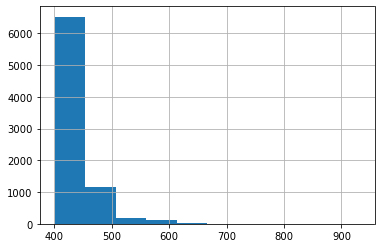

In [29]:
import pandas as pd
from matplotlib import pyplot as plt

# load & inspect dataset
df = pd.read_csv('novel_paragraph.csv', encoding='utf-8')
df['Token'].hist()
# df_500 = df[df['Token'] > 700]
# df_500


# df[['Token']].hist()
# # add axis descriptions and title
# plt.xlabel('Number of tokens')
# plt.ylabel('Number of Wikipedia sections')
# plt.title('Distribution of number of tokens in Wikipedia sections')
# plt.show()